# Prophet - Predecir el valor de Bitcoin


Prophet es una de las librerías más avanzadas para predecir series temporales desarrollada por Facebook. Te enseñaremos a como entrenar un modelo con Prophet, a optimizarlo y a utilizarlo para realizar predicciones futuras. En este ejercicio vamos a practicar a predecir el valor de Bitcoin, una criptomoneda. Es la criptomoneda que le ha marcado el camino a todas las demás que llegaron después utilizando su tecnología.  

<hr/>
<div class="alert alert-success alertsuccess" style="margin-top: 20px">
[Tip]: Para ejecutar el código de Python en la celda de código a continuación, haz clic en la celda para seleccionarla y presiona <kbd>Shift</kbd> + <kbd>Enter</kbd>.
</div>
<hr/>


In [1]:
# Instalamos el modelo predictivo Prophet
!python -m pip install prophet --quiet
# De aquí vamos a descargar los datos
!pip install yfinance --quiet

In [2]:
#Importamos las dependencias
import pandas as pd
import yfinance as yf
from datetime import datetime
from datetime import timedelta
import plotly.graph_objects as go
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import warnings

warnings.filterwarnings('ignore')

pd.options.display.float_format = '${:,.2f}'.format

<h3 id="version">Cargar histórico de datos</h3>


<p>
    Para descargarnos la serie temporal de BTC lo vamos a hacer desde Yahoo Finance. En concreto vamos a descargar el histórico desde 2016 hasta la actualidad.
</p>



In [7]:
# Fecha de inicio es un string 2016-01-01 y fecha de fin (hoy) en formato texto '%Y-%m-%d'
today = ('2023-06-07')
start_date = '2016-01-01'
# Descargar el dataframe
btc_df = yf.download('BTC-USD',start_date, today).reset_index()

btc_df.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
2709,2023-06-02,"$26,824.56","$27,303.86","$26,574.64","$27,249.59","$27,249.59",14837415000
2710,2023-06-03,"$27,252.32","$27,317.05","$26,958.00","$27,075.13","$27,075.13",8385597470
2711,2023-06-04,"$27,075.12","$27,407.02","$26,968.22","$27,119.07","$27,119.07",9360912318
2712,2023-06-05,"$27,123.11","$27,129.98","$25,445.17","$25,760.10","$25,760.10",21513292646
2713,2023-06-06,"$25,732.11","$27,313.82","$25,434.87","$27,238.78","$27,238.78",21929670693


In [13]:
# Validamos que no hay datos vacíos
if btc_df.empty:
  print('DataFrame is empty')
else:
  print('DataFrame is not empty')
btc_df

DataFrame is not empty


,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-01,$430.72,$436.25,$427.52,$434.33,$434.33,36278900
1,2016-01-02,$434.62,$436.06,$431.87,$433.44,$433.44,30096600
2,2016-01-03,$433.58,$433.74,$424.71,$430.01,$430.01,39633800
3,2016-01-04,$430.06,$434.52,$429.08,$433.09,$433.09,38477500
4,2016-01-05,$433.07,$434.18,$429.68,$431.96,$431.96,34522600
...,...,...,...,...,...,...,...
2709,2023-06-02,"$26,824.56","$27,303.86","$26,574.64","$27,249.59","$27,249.59",14837415000
2710,2023-06-03,"$27,252.32","$27,317.05","$26,958.00","$27,075.13","$27,075.13",8385597470
2711,2023-06-04,"$27,075.12","$27,407.02","$26,968.22","$27,119.07","$27,119.07",9360912318
2712,2023-06-05,"$27,123.11","$27,129.98","$25,445.17","$25,760.10","$25,760.10",21513292646


In [22]:
# TAREA: Filtramos el dataframe para quedarnos solo las columnas "Date" y "Open"
# Date será la fecha del valor y Open el valor del BTC en ese momento
df = btc_df [['Date', 'Open']]

# Valores que espera el prophet
# Eje X: Indíce llamado ds
# Eje Y: Serie a predecir llamada y
# TAREA HECHA: Crear un diccionario con clave "Date" y valor "ds"
# Y otra clave "Open" y valor "y"
new_names = {
    "Date": "ds", 
    "Open": "y",
}

# TAREA: Utiliza el diccionario para renombrar las columnas de df
df.rename(columns = new_names, inplace = True)
df

,ds,y
0,2016-01-01,$430.72
1,2016-01-02,$434.62
2,2016-01-03,$433.58
3,2016-01-04,$430.06
4,2016-01-05,$433.07
...,...,...
2709,2023-06-02,"$26,824.56"
2710,2023-06-03,"$27,252.32"
2711,2023-06-04,"$27,075.12"
2712,2023-06-05,"$27,123.11"


In [23]:
#Ejecuta la siguiente línea, si lo has hecho bien hasta aquí no dará error
df['ds'] = df['ds'].dt.tz_localize(None)

In [24]:
df.tail()

,ds,y
2709,2023-06-02,"$26,824.56"
2710,2023-06-03,"$27,252.32"
2711,2023-06-04,"$27,075.12"
2712,2023-06-05,"$27,123.11"
2713,2023-06-06,"$25,732.11"


In [25]:
# Crear la gráfica del precio de apertura
#Asigna a la variable x la columna ds
x = df["ds"]
#Asigna a la variable y la columna y
y = df["y"]

fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=y))

# Le ponemos el título a la gráfica
titulo = ""
fig.update_layout(
    title_text=titulo,
)

fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list(
                [
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1a", step="year", stepmode="backward"),
                    dict(step="all"),
                ]
            )
        ),
        rangeslider=dict(visible=True),
        type="date",
    )
)

<h3 id="version">Entrenar y predecir el modelo</h3>


<p>
    Ahora que has visto en la gráfica de que datos partimos. Inicializamos el Prophet y lo entramos pasandole el dataframe
</p>



In [32]:
import prophet
#TAREA: Inicializa Prophet en la variable m con seasonality_mode en modo "multiplicative"
m = Prophet(seasonality_mode = 'multiplicative')





INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbwkb_te7/qz7shzpq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbwkb_te7/mk2g57at.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36707', 'data', 'file=/tmp/tmpbwkb_te7/qz7shzpq.json', 'init=/tmp/tmpbwkb_te7/mk2g57at.json', 'output', 'file=/tmp/tmpbwkb_te7/prophet_model117n46y0/prophet_model-20230607083520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:35:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:35:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


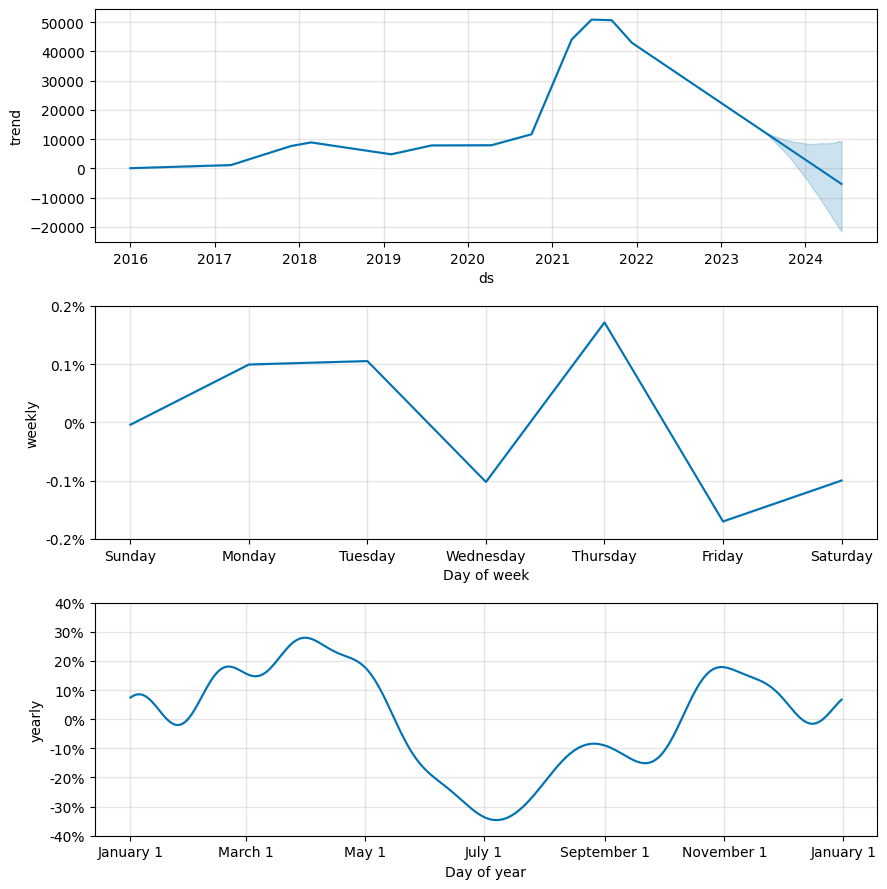

In [33]:
#TAREA: Entrena el modelo m con el dataframe de datos df
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig = m.plot_components (forecast)


<p>
    Le decimos al modelo m los días en futuro que queremos predecir, en este caso el próximo año.
</p>



In [34]:
# TAREA: generar un dataframe con los días que tenemos y los 365 días siguientes a hoy para predecirlo
# PISTA: puedes usar la función del prophet make_future_dataframe()
future = m.make_future_dataframe (periods=365)
future.tail()

,ds
3074,2024-06-01
3075,2024-06-02
3076,2024-06-03
3077,2024-06-04
3078,2024-06-05


In [ ]:
# En el caso que hayas elegido un valor o fondo tradicional, es decir, que no opere los fines
# de semana, descomenta la siguiente línea:

# future = future[ future['ds'].dt.dayofweek < 5 ] # Nos elimina los fines de semana de 'ds' para no predecirlos
future 

<p>
    Al modelo entrenado le pasamos el dataframe a predecir.
</p>



In [36]:
#Utiliza el modelo m para predecir el dataframe future
forecast = m.predict(future) 

In [37]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3074,2024-06-01,"$-4,226.36","$-18,242.13","$9,289.86"
3075,2024-06-02,"$-4,241.87","$-17,628.86","$9,196.77"
3076,2024-06-03,"$-4,258.99","$-17,159.91","$9,811.80"
3077,2024-06-04,"$-4,271.94","$-18,209.58","$8,944.34"
3078,2024-06-05,"$-4,274.09","$-18,201.44","$9,475.10"


<p>
    Gráfica con el modelo entrenado y los valores de un año en futuro predecidos.
</p>



In [38]:
next_day = (datetime.today() + timedelta(days=1)).strftime('%Y-%m-%d')
forecast[forecast['ds'] == next_day]['yhat'].item()
plot_plotly(m, forecast)

In [ ]:
plot_components_plotly(m, forecast)